In [1]:
import oceanspy as ospy
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import scipy as sp
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [2]:
df = xr.open_dataset('C:/Users/eirik/Master/Data/Depth_res.nc')

In [3]:
df

<xarray.Dataset>
Dimensions:    (Z: 216, Zp1: 217, Zu: 216, Zl: 216, X: 960, Y: 880, Xp1: 961,
                Yp1: 881, time: 1460, time_midp: 1459)
Coordinates: (12/18)
  * Z          (Z) float64 -1.0 -3.5 -7.0 ... -3.904e+03 -3.922e+03 -3.942e+03
  * Zp1        (Zp1) float64 0.0 -2.0 -5.0 ... -3.913e+03 -3.932e+03 -3.951e+03
  * Zu         (Zu) float64 -2.0 -5.0 -9.0 ... -3.913e+03 -3.932e+03 -3.951e+03
  * Zl         (Zl) float64 0.0 -2.0 -5.0 ... -3.894e+03 -3.913e+03 -3.932e+03
  * X          (X) float64 -45.0 -44.76 -44.52 -44.29 ... 23.29 23.52 23.76 24.0
  * Y          (Y) float64 57.0 57.08 57.17 57.25 ... 78.75 78.83 78.92 79.0
    ...         ...
  * time       (time) datetime64[ns] 2017-09-01 ... 2018-08-31T18:00:00
    YU         (Y, Xp1) float64 ...
    XU         (Y, Xp1) float64 ...
    YV         (Yp1, X) float64 ...
    XV         (Yp1, X) float64 ...
  * time_midp  (time_midp) datetime64[ns] 2017-09-01T03:00:00 ... 2018-08-31T...
Data variables:
    dxF        (Y, X) float64 ...
    dyF        (Y, X) float64 ...
    Depth      (Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     NorthPolarStereo(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

In [4]:
depth = df['Depth']
x_res = df['dxF']*(1/1000)
y_res = df['dyF']*(1/1000)



res = np.sqrt(x_res*y_res)
res_smooth = sp.ndimage.gaussian_filter(res, sigma=1)
print("Shape of res_smooth:", res_smooth.shape)
print("Shape of res:", res.shape)

Shape of res_smooth: (880, 960)
Shape of res: (880, 960)


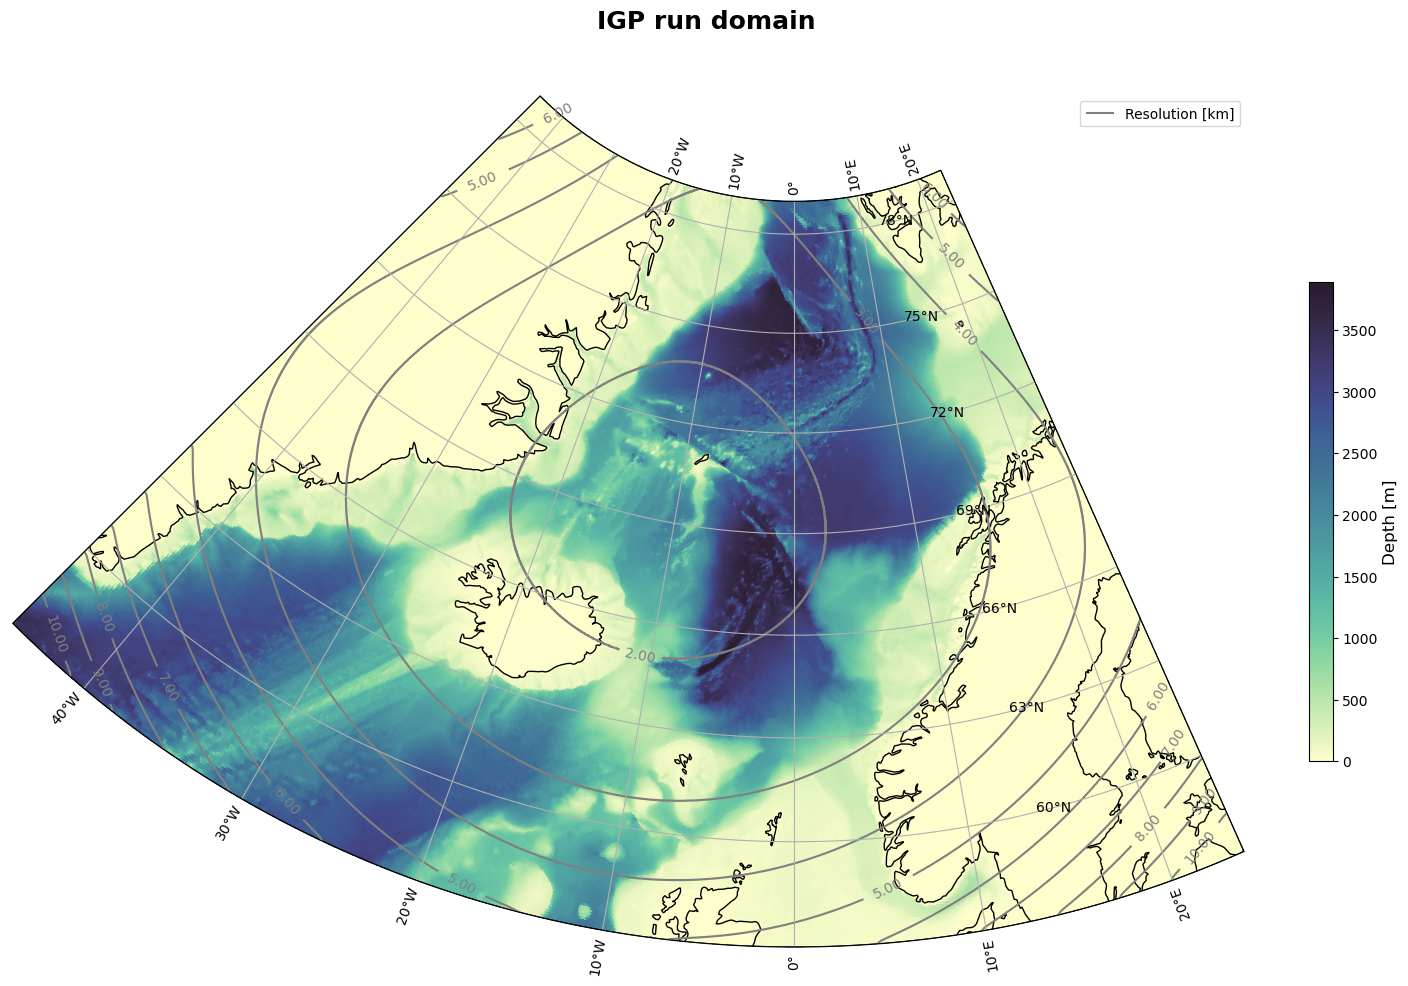

In [6]:
lon = depth['XC']
lat = depth['YC']

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw=dict(projection=ccrs.NorthPolarStereo()),layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-45, 24, 57, 79]
#ax.set_extent(extent, crs=ccrs.PlateCarree()) # Do not use, cuts the bottom part of domain in projection

# Add coastlines and other features
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
ax.add_feature(cfeature.OCEAN, zorder=0)

# Plot the data using pcolormesh
mesh = ax.pcolormesh(lon, lat, depth, cmap=cmo.deep, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('Depth [m]',fontsize=12)

# Add contour of dataset resolution
cntr = ax.contour(res.X, res.Y, res_smooth,[2,3,4,5,6,7,8,9,10], colors='grey',transform=ccrs.PlateCarree())
ax.clabel(cntr,fmt="%2.2f",use_clabeltext=True)
h1, _ = cntr.legend_elements()
ax.legend([h1[0]],['Resolution [km]'])

# Create a custom path for the extent in PlateCarree projection
# Generate more points along the top and bottom extents to approximate the curve
num_points = 1000
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

fig.suptitle('IGP run domain',fontweight='bold',fontsize=18)
plt.savefig('C:/Users/eirik/Master/Figures/IGPDomain')
